<a href="https://colab.research.google.com/github/nkmah2/Deep-Learning/blob/master/Accuracy_vs_Unbalanced_Datasets_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# DL      
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [30]:
# Number operations
import numpy as np
import scipy.stats as stats
# Data management
import pandas as pd
# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# Import wine data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']< 200]

# z-score all columns except quality
col2zscore = data.keys()
col2zscore = col2zscore.drop('quality')
data[col2zscore] = data[col2zscore].apply(stats.zscore)

In [32]:
# Process the data by quality threshold

def createDataset(qualThresh):
  data['boolQuality'] = 0

  tmp = (data['quality']> qualThresh).astype(int)
  data['boolQuality'] = tmp

  dataT = torch.tensor(data[col2zscore].values).float()
  labels = torch.tensor(data['boolQuality'].values).float()
  labels = labels[:,None] # transform the matrix

  train_data,test_data, train_labels,test_labels = train_test_split(dataT,labels,test_size=0.1)

  train_data = TensorDataset(train_data,train_labels)
  test_data = TensorDataset(test_data,test_labels)


  batchSize = 8
  train_loader = DataLoader(train_data,batch_size=batchSize,shuffle=True,drop_last=True)
  test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

  return train_loader,test_loader

In [47]:
# test the dataset and the number of samples

# note that the data are roughly balanced with thresh=5, not 4 or 6
train_loader,test_loader = createDataset(4)

# get number of high/low quality wines
qualityRatings = train_loader.dataset.tensors[1].detach()
print('%s low-rated wines' %torch.sum(qualityRatings==0).item())
print('%s high-rated wines' %torch.sum(qualityRatings==1).item())

59 low-rated wines
1378 high-rated wines


In [48]:
# The DL section

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    # input layer
    self.input = nn.Linear(11,32)

    # hidden layer
    self.fc1 = nn.Linear(32,32)
    self.fc2 = nn.Linear(32,32)

    #outout
    self.output = nn.Linear(32,1)

  def forward(self,x):
    x = F.leaky_relu(self.input(x)) # leaky relu just for a change
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    return self.output(x)

      


In [43]:
#from torch.optim import optimizer
# Train the DL model

numEpochs = 500

def trainModel():

  lossFun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  losses = torch.zeros(numEpochs)
  trainAcc = []
  testAcc = []

  for epochi in range(numEpochs):
    batchAcc = []
    batchLoss = []

    for X,y in train_loader:
      yHat = winenet(X)
      loss = lossFun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

    # Get the avg acc after training through the batch
    trainAcc.append(np.mean(batchAcc))

    losses[epochi] =np.mean(batchLoss)

    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  return trainAcc, testAcc, losses



In [49]:
# Test the model
train_loader, test_loader = createDataset(5)

# Create the model and train it
winenet = ANNwine()
trainAcc, testAcc, losses = trainModel()
# Compute the accuracy as per quality type
X,y = next(iter(test_loader))
yHat = winenet(X)

itemAccuracy = ((yHat>0) == y).float()
perQualAcc = [ 100*torch.mean(itemAccuracy[y==0]) ,100*torch.mean(itemAccuracy[y==1]) ]
perQualAcc


[tensor(75.7576), tensor(87.2340)]

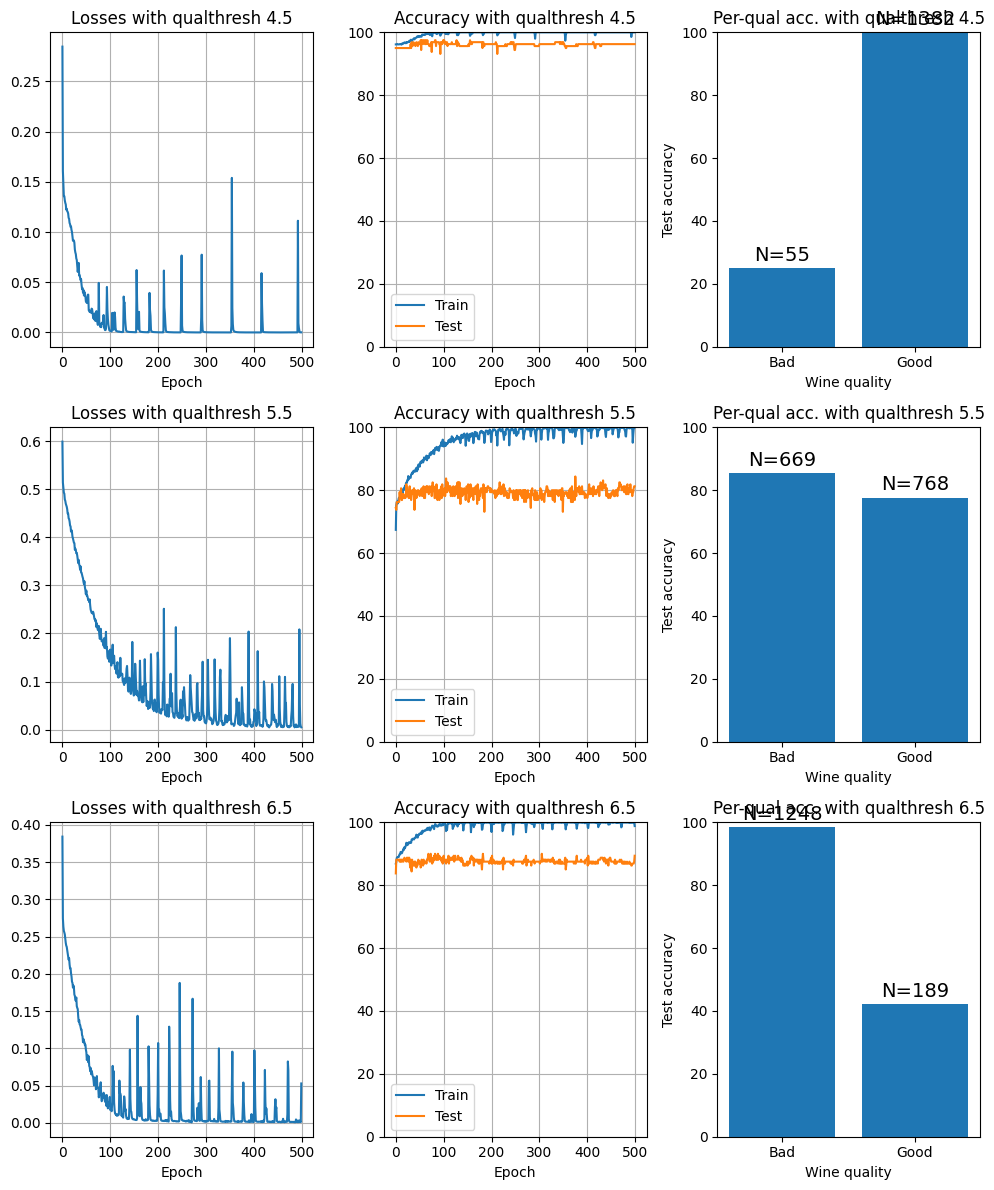

In [46]:
# Train for different quality thresholds

fig,ax = plt.subplots(3,3,figsize=(10,12))
quality_thresholds = [4,5,6]

for q in range(len(quality_thresholds)):
  train_loader,test_loader = createDataset(quality_thresholds[q])
  winenet = ANNwine()
  trainAcc, testAcc, losses = trainModel()

  X,y = next(iter(test_loader))
  yHat = winenet(X)
  itemAccuracy = ((yHat>0) == y).float()
  perQualAcc = [ 100*torch.mean(itemAccuracy[y==0]) ,100*torch.mean(itemAccuracy[y==1]) ]
  
  # plot losses
  ax[q,0].plot(losses)
  ax[q,0].set_title('Losses with qualthresh ' + str(quality_thresholds[q]+.5))
  ax[q,0].set_xlabel('Epoch')
  ax[q,0].grid()

  # plot overall accuracy
  ax[q,1].plot(trainAcc,label='Train')
  ax[q,1].plot(testAcc,label='Test')
  ax[q,1].set_title('Accuracy with qualthresh ' + str(quality_thresholds[q]+.5))
  ax[q,1].legend()
  ax[q,1].set_xlabel('Epoch')
  ax[q,1].set_ylim([0,100])
  ax[q,1].grid()

  # plot the per-quality accuracy
  bh = ax[q,2].bar(['Bad','Good'],perQualAcc)
  ax[q,2].set_ylim([0,100])
  ax[q,2].set_xlabel('Wine quality')
  ax[q,2].set_ylabel('Test accuracy')
  ax[q,2].set_title('Per-qual acc. with qualthresh ' + str(quality_thresholds[q]+.5))

  # print the counts on top of each bar
  for i,r in enumerate(bh):
    N = torch.sum(train_loader.dataset.tensors[1]==i).item()
    ax[q,2].text(r.get_x()+r.get_width()/2, r.get_height()+1,
              'N=%s'%N, ha='center', va='bottom', fontsize=14)


plt.tight_layout()
plt.show()






In [50]:
# Reference:
# LECTURE: CodeChallenge: unbalanced data
# TEACHER: Mike X Cohen, sincxpress.com
# COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202303